# ЛР 9 Нейронные сети Автоэнкодеры

Булатова Ксения

Группа: ПМИ - 24 НМ



## Описание данных

Для работы был взят [датасет](https://www.kaggle.com/datasets/arashnic/uplift-modeling) с данными маркетигновой кампании.

**Содержание**

Набор данных создан лабораторией искусственного интеллекта Criteo.Набор данных состоит из 13 миллионов строк, каждая из которых представляет пользователя с 12 характеристиками, индикатором обращения и двумя бинарными метками (посещения и конверсии). Положительные метки означают, что пользователь посетил / конвертировал веб-сайт рекламодателя в течение тестового периода (2 недели). Глобальный коэффициент обращения составляет 84,6%. Обычно рекламодатели сохраняют лишь небольшую контрольную группу, поскольку это обходится им в потенциальный доход.

**Описание функций**

*f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11*: значения признаков (плотные, с плавающей точкой)

*treatment*: просмотрел рекламное объявление (1 = да, 0 = нет)

*conversion:* произошла ли конверсия для этого пользователя (1 = да, 0 = нет)

*visit:* произошло ли посещение этого пользователя (1 = да, 0 = нет)

*exposure:* эффект от рекламного объявления, подвергся ли пользователь эффективному воздействию (1 = да, 0 = нет)

**Задача:**
Распознать эфективное воздействие от рекламного объявления

Так как датасет очень большой (13 млн. строк) для работы взяла 5% данных

[criteo.csv](https://drive.google.com/file/d/1IqmuOl2BsST2thZe13d50tR0V_IdP2sa/view?usp=drive_link)

In [2]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["No target action", "Target action"]

Загружаем данные

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/data/criteo.csv')

In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,26.112987,10.059654,8.214383,4.679882,10.280525,4.115453,-4.595460,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
1,21.845827,10.059654,8.214383,4.679882,10.280525,4.115453,-8.058865,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
2,26.063724,10.059654,8.214383,4.679882,10.280525,4.115453,-11.944313,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
3,26.020582,10.059654,8.960948,4.679882,10.280525,4.115453,-5.116672,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,20.935495,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [7]:
print(df.shape)
print(df.describe())

(698980, 16)
                  f0             f1             f2             f3  \
count  698980.000000  698980.000000  698980.000000  698980.000000   
mean       19.625927      10.070119       8.446540       4.179379   
std         5.375840       0.105340       0.299283       1.336106   
min        12.616365      10.059654       8.214383      -6.554029   
25%        12.616365      10.059654       8.214383       4.679882   
50%        21.924823      10.059654       8.214383       4.679882   
75%        24.446644      10.059654       8.725727       4.679882   
max        26.745255      15.600396       9.051961       4.679882   

                  f4             f5             f6             f7  \
count  698980.000000  698980.000000  698980.000000  698980.000000   
mean       10.339246       4.027697      -4.158068       5.103704   
std         0.345876       0.433094       4.582888       1.209881   
min        10.280525      -7.781469     -29.454279       4.833815   
25%        10.280525

In [8]:
df.isnull().values.any()

False

пропусков нет

In [9]:
df['exposure'].value_counts()

,count
exposure,
0,677648
1,21332


<ipython-input-10-89797c3827c8>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['exposure'], sort = True)


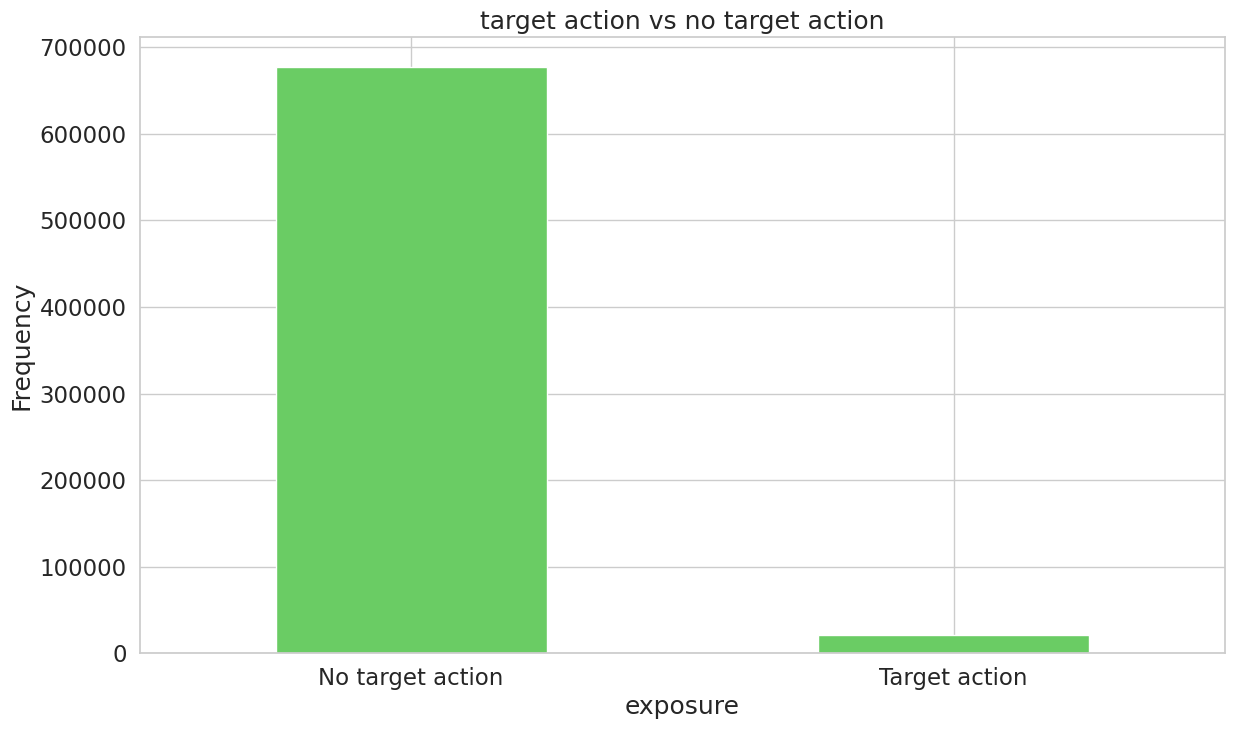

In [10]:
count_classes = pd.value_counts(df['exposure'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("target action vs no target action")
plt.xticks(range(2), LABELS)
plt.xlabel("exposure")
plt.ylabel("Frequency");

Набор данных сильно не сбалансирован в пользу 0 (отсутствие активных действий)

In [11]:
targetDF = df[df.exposure == 1]
no_targetDF = df[df.exposure == 0]

In [12]:
targetDF.shape

(21332, 16)

In [13]:
no_targetDF.shape

(677648, 16)

Рассмотрим зафиксированные действия пользователей при положительном и отрицательном действии рекламы

Text(0.5, 1.0, 'Просмотр рекламы в случае неактивных действий')

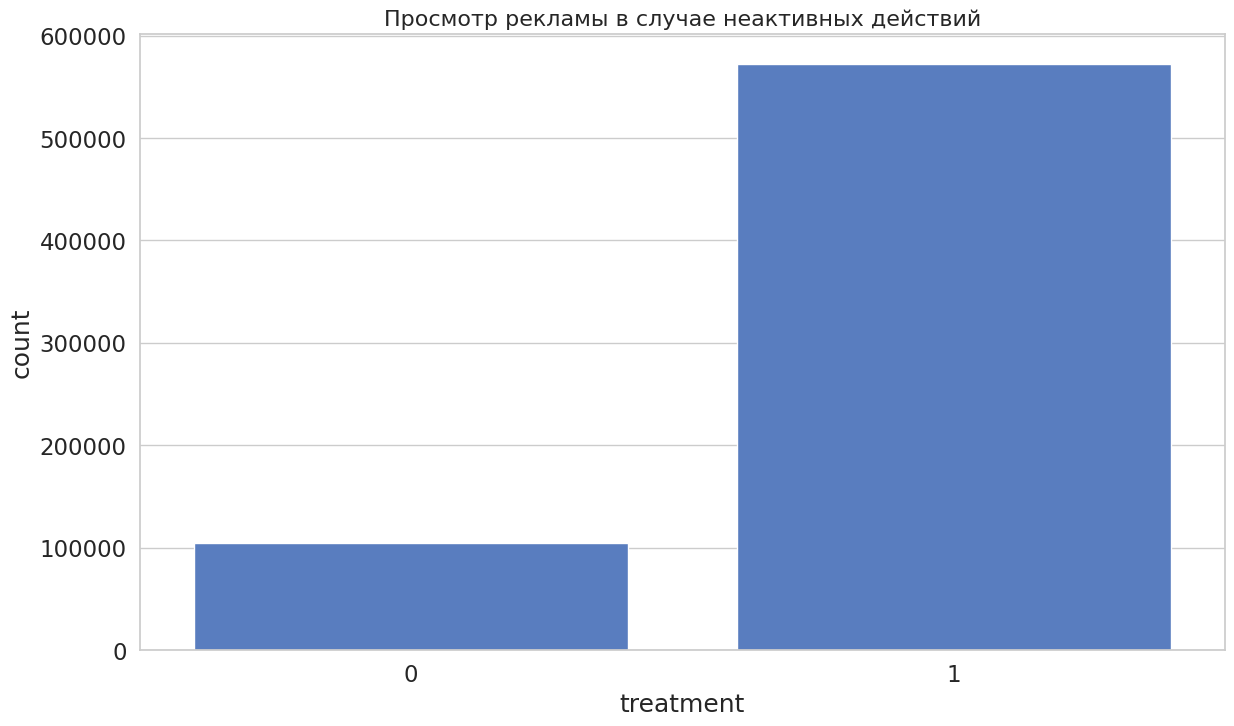

In [14]:
sns.countplot(x=no_targetDF.treatment);

plt.title('Просмотр рекламы в случае неактивных действий', fontsize = 16)

Text(0.5, 1.0, 'Просмотр рекламы в случае активных действий')

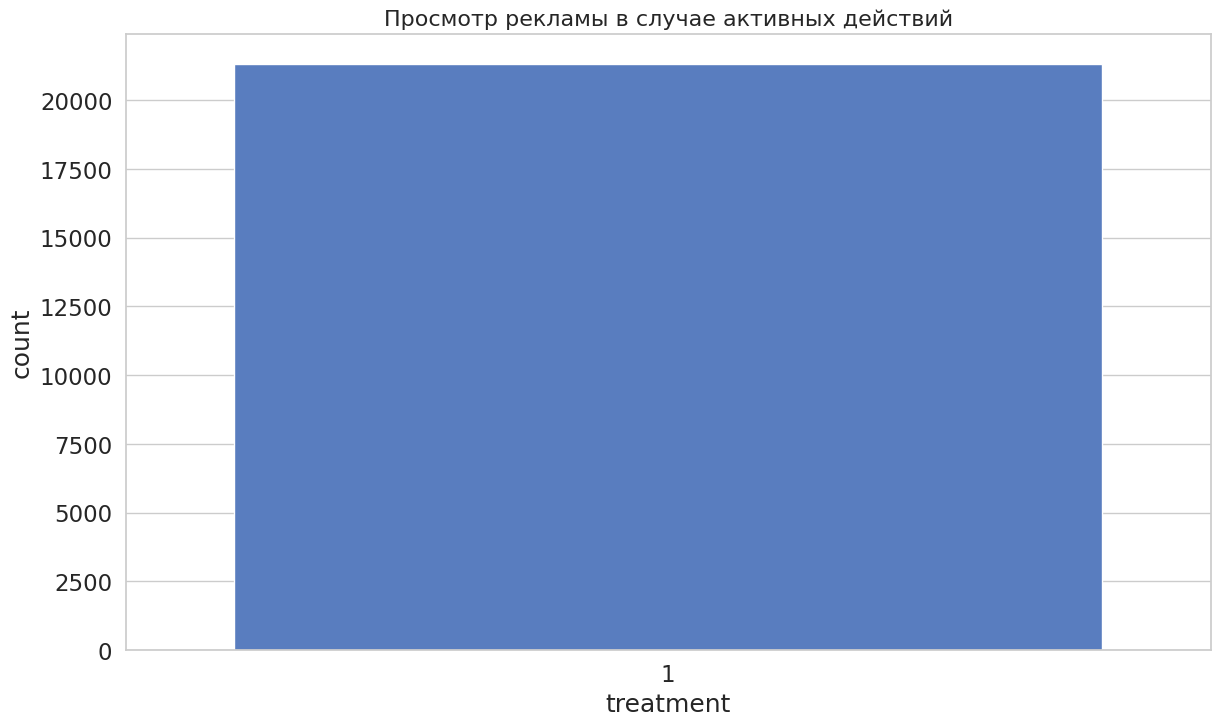

In [15]:
sns.countplot(x=targetDF.treatment);

plt.title('Просмотр рекламы в случае активных действий', fontsize = 16)

Text(0.5, 1.0, 'Посещение пользователя в случае неактивных действий')

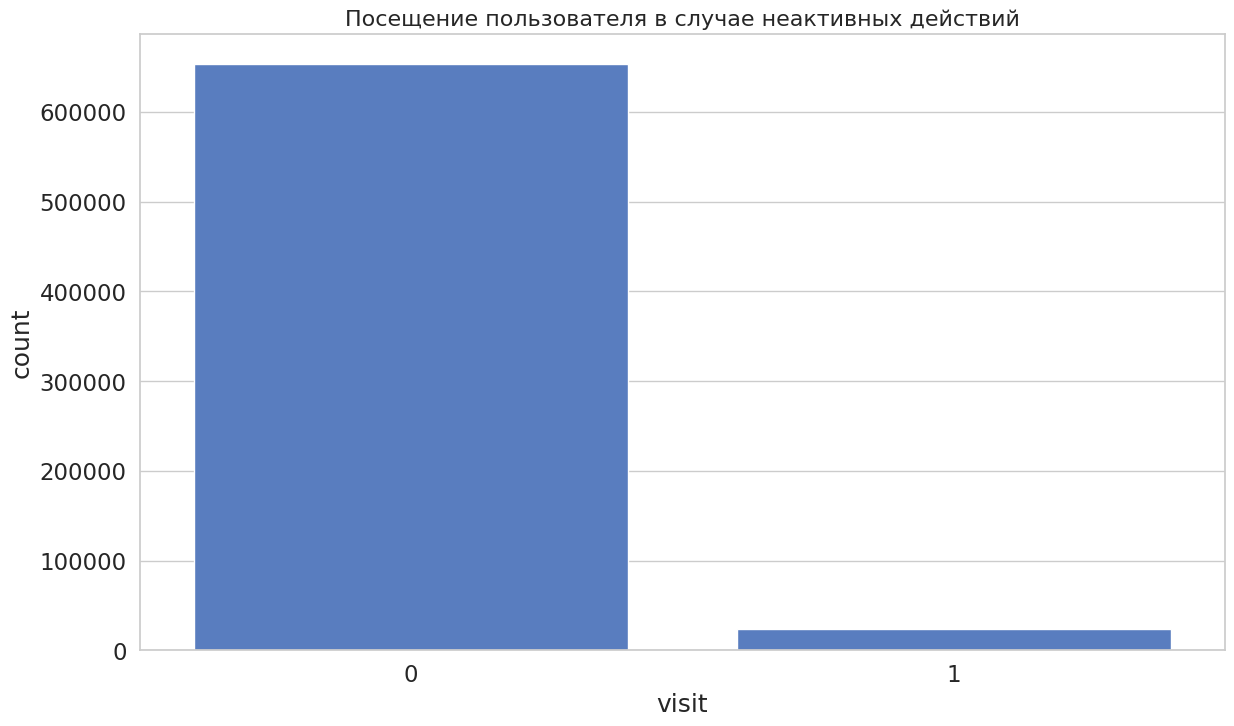

In [16]:
sns.countplot(x=no_targetDF.visit);

plt.title('Посещение пользователя в случае неактивных действий', fontsize = 16)

Text(0.5, 1.0, 'Посещение пользователя в случае активных действий')

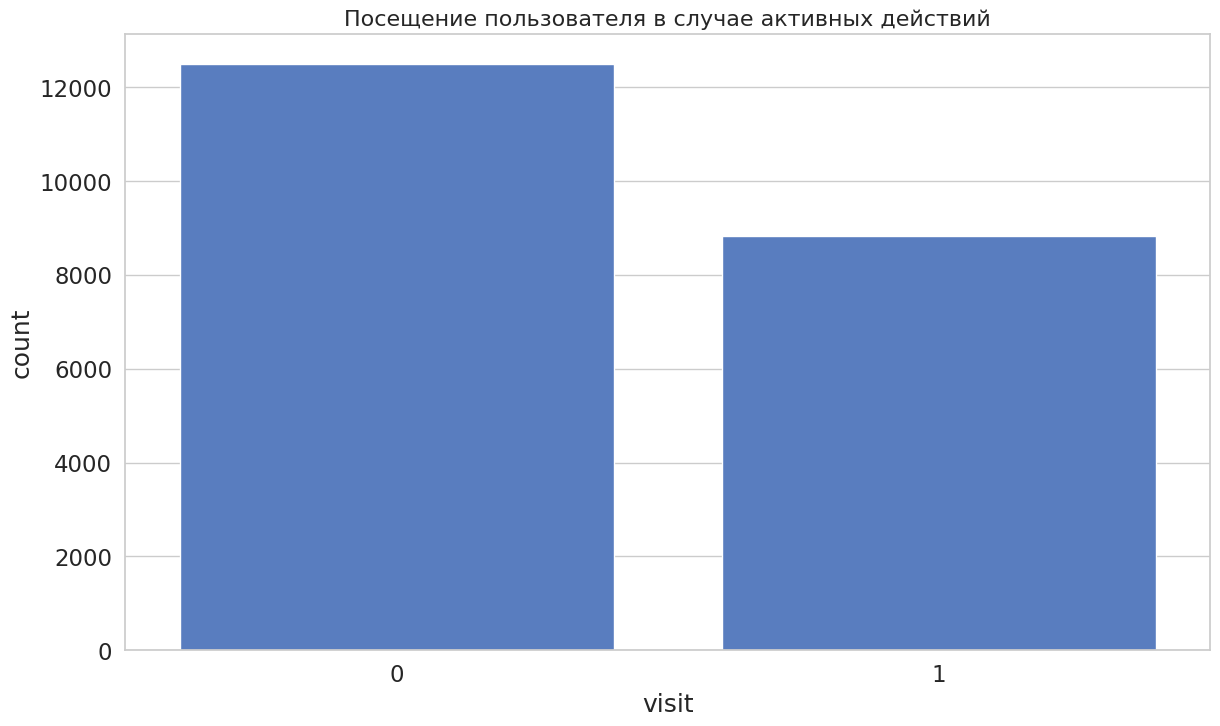

In [17]:
sns.countplot(x=targetDF.visit);

plt.title('Посещение пользователя в случае активных действий', fontsize = 16)

Text(0.5, 1.0, 'Конверсия пользователя в случае неактивных действий')

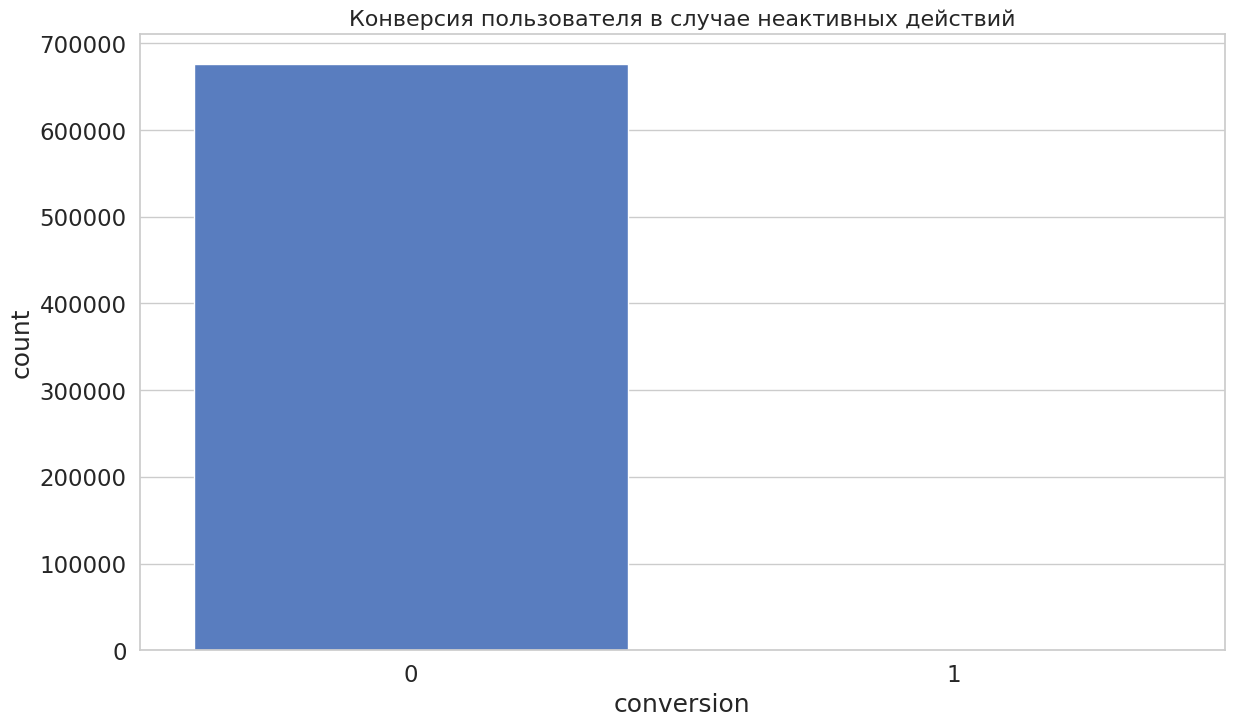

In [18]:
sns.countplot(x=no_targetDF.conversion);

plt.title('Конверсия пользователя в случае неактивных действий', fontsize = 16)

Text(0.5, 1.0, 'Конверсия пользователя в случае активных действий')

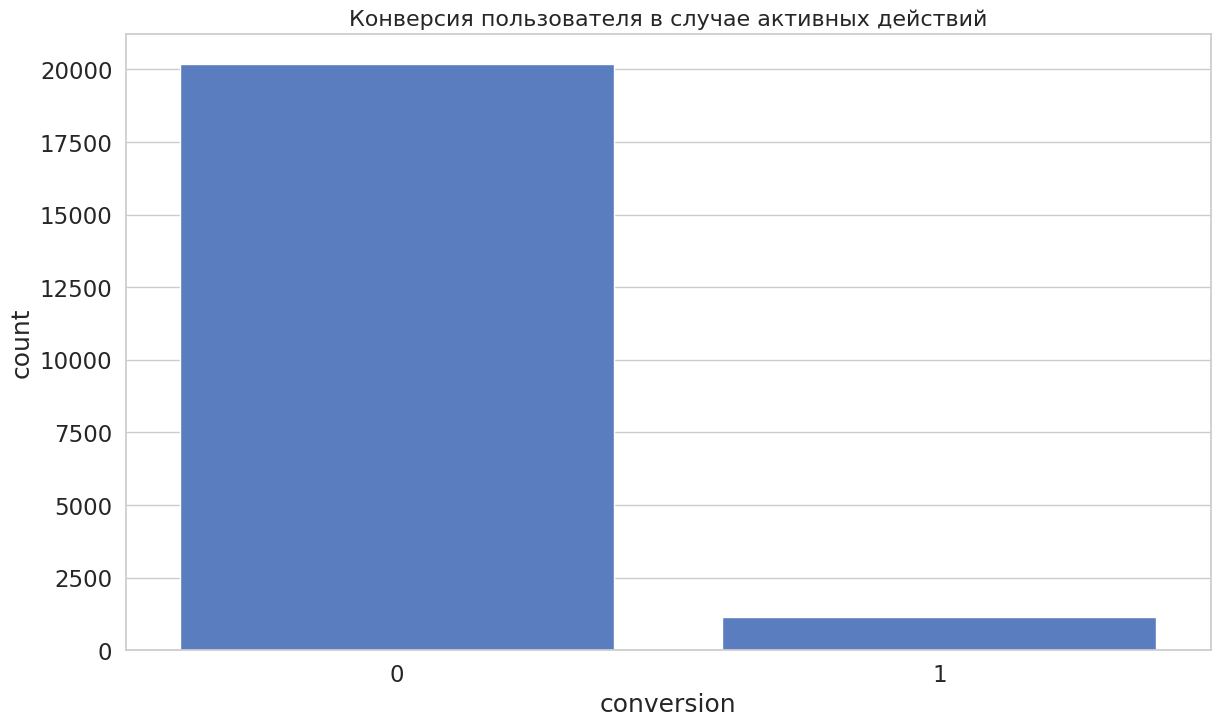

In [19]:
sns.countplot(x=targetDF.conversion);

plt.title('Конверсия пользователя в случае активных действий', fontsize = 16)

Конверсия пользотеля не влияет на целевое действие

In [20]:
df = df.drop(['conversion'], axis=1)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698980 entries, 0 to 698979
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   f0         698980 non-null  float64
 1   f1         698980 non-null  float64
 2   f2         698980 non-null  float64
 3   f3         698980 non-null  float64
 4   f4         698980 non-null  float64
 5   f5         698980 non-null  float64
 6   f6         698980 non-null  float64
 7   f7         698980 non-null  float64
 8   f8         698980 non-null  float64
 9   f9         698980 non-null  float64
 10  f10        698980 non-null  float64
 11  f11        698980 non-null  float64
 12  treatment  698980 non-null  int64  
 13  visit      698980 non-null  int64  
 14  exposure   698980 non-null  int64  
dtypes: float64(12), int64(3)
memory usage: 80.0 MB


## Разделим набор данных на наборы обучающих и тестовых двнных

Обучение 80%

Тест 20%

В обучающем наборе будут данные только с целевыми действиями, в тестовом с целевыми и не целевыми действиями

In [22]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.exposure == 0]
X_train = X_train.drop(['exposure'], axis=1)
y_test = X_test['exposure']
X_test = X_test.drop(['exposure'], axis=1)

X_train = X_train.values
X_test = X_test.values
y_test = y_test.values
print(y_test.size)

139796


## Модель

Построим автоэнкодер, состоящий из 4 полносвязных слоев с 8,6,6,14 нейронами.

In [73]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(14, 8),
            nn.Tanh(),
            nn.Linear(8, 6),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(6, 6),
           nn.Tanh(),
           nn.Linear(6, 14),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [74]:
model = Autoencoder().double()

In [75]:
num_epochs = 100
minibatch_size = 17
learning_rate = 1e-3

In [76]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

In [77]:
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [81]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=10e-09)

In [82]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [83]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './criteo_model.pth')

epoch [1/100], loss:1.6900
epoch [2/100], loss:1.2984
epoch [3/100], loss:0.9568
epoch [4/100], loss:0.6434
epoch [5/100], loss:0.4945
epoch [6/100], loss:0.3995
epoch [7/100], loss:0.3334
epoch [8/100], loss:0.2883
epoch [9/100], loss:0.2566
epoch [10/100], loss:0.2353
epoch [11/100], loss:0.2195
epoch [12/100], loss:0.2080
epoch [13/100], loss:0.2001
epoch [14/100], loss:0.1932
epoch [15/100], loss:0.1873
epoch [16/100], loss:0.1826
epoch [17/100], loss:0.1784
epoch [18/100], loss:0.1749
epoch [19/100], loss:0.1660
epoch [20/100], loss:0.1154
epoch [21/100], loss:0.0968
epoch [22/100], loss:0.0923
epoch [23/100], loss:0.0896
epoch [24/100], loss:0.0869
epoch [25/100], loss:0.0851
epoch [26/100], loss:0.0837
epoch [27/100], loss:0.0819
epoch [28/100], loss:0.0802
epoch [29/100], loss:0.0790
epoch [30/100], loss:0.0781
epoch [31/100], loss:0.0771
epoch [32/100], loss:0.0759
epoch [33/100], loss:0.0751
epoch [34/100], loss:0.0744
epoch [35/100], loss:0.0740
epoch [36/100], loss:0.0727
e

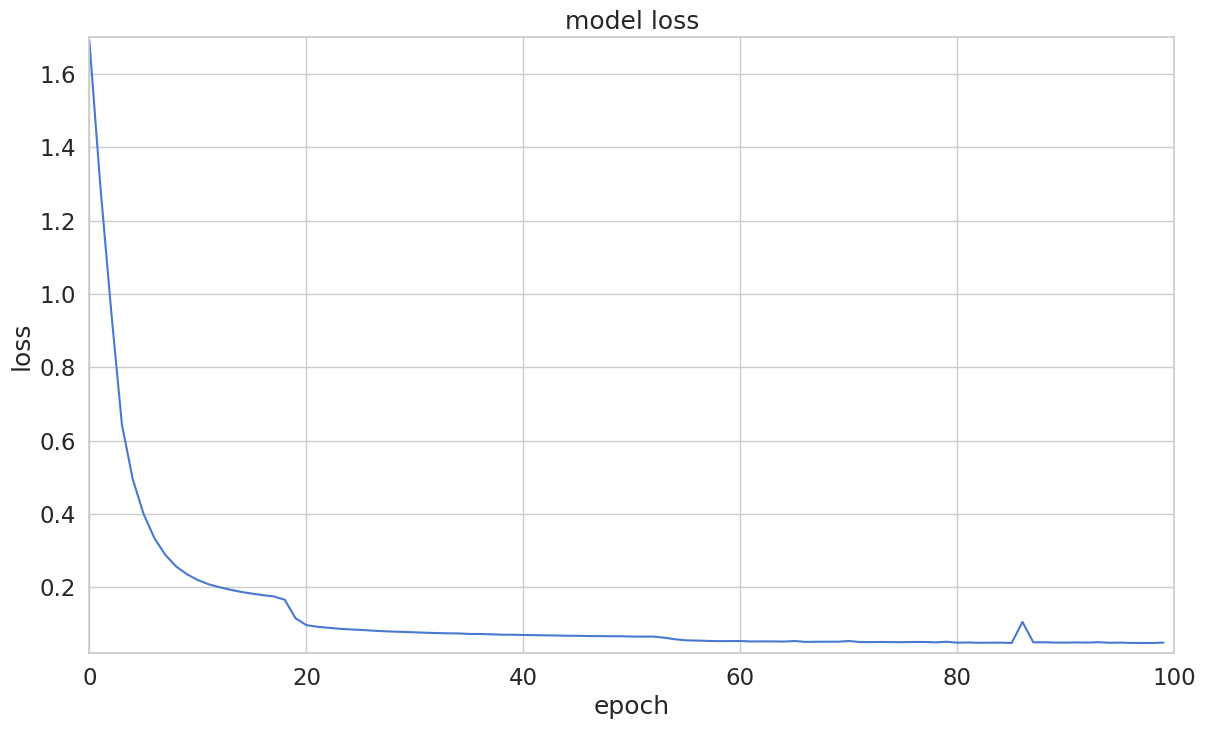

In [84]:
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0.02,1.7])
plt.show()

## Оценка модели

In [85]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['exposure'] = y_test

In [86]:
reconstructionErrorDF.describe()

,pred_loss,exposure
count,139796.000000,139796.000000
mean,0.067296,0.030545
std,0.216281,0.172081
min,0.002695,0.000000
25%,0.013278,0.000000
50%,0.019850,0.000000
75%,0.064346,0.000000
max,11.380133,1.000000


### Оценка рекострукций для неактивных действий

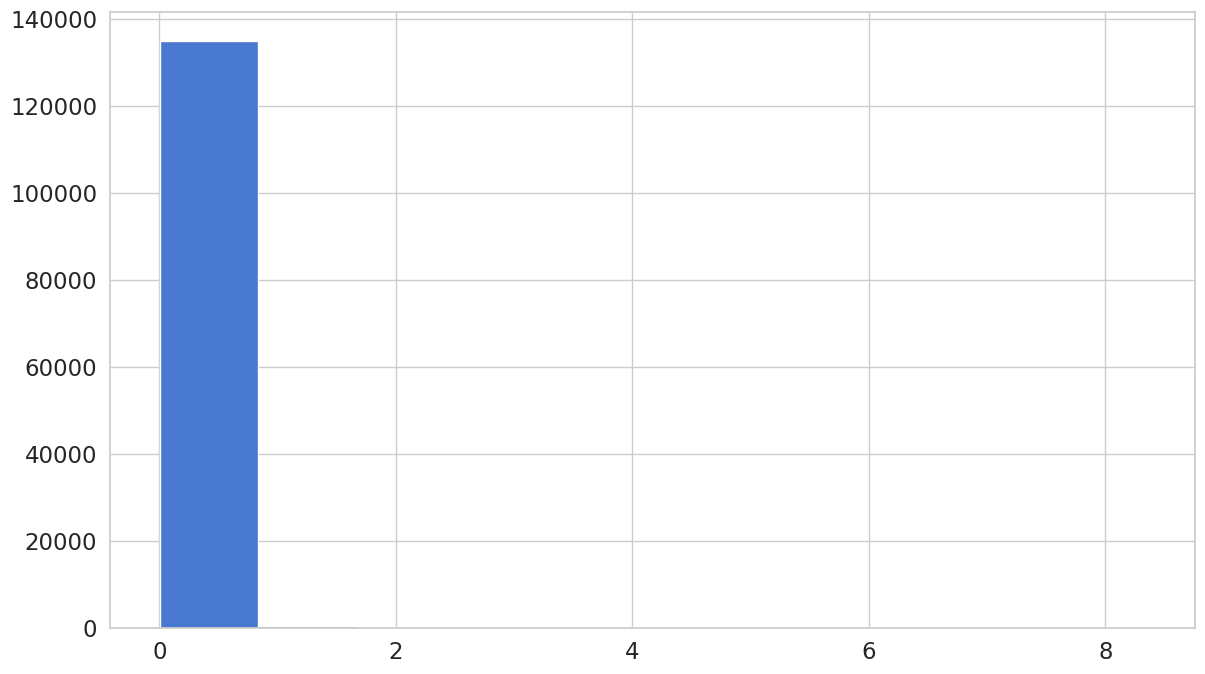

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['exposure']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

### Ошибка реконструкций для активных действий

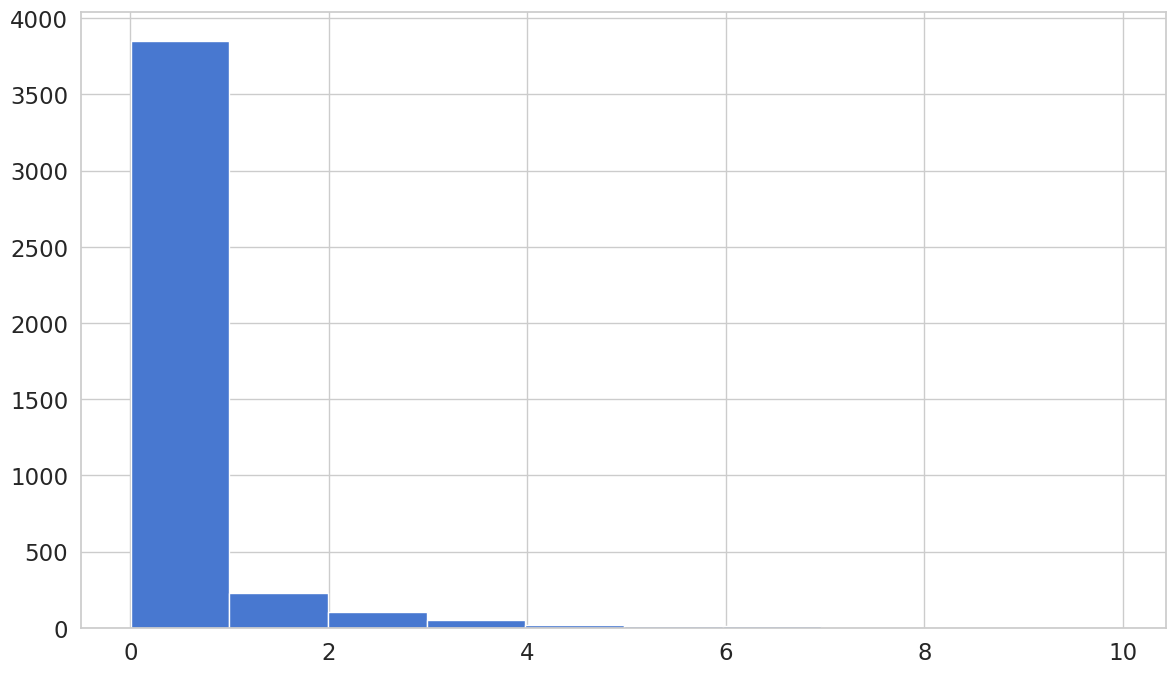

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['exposure']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

### ROC - кривая

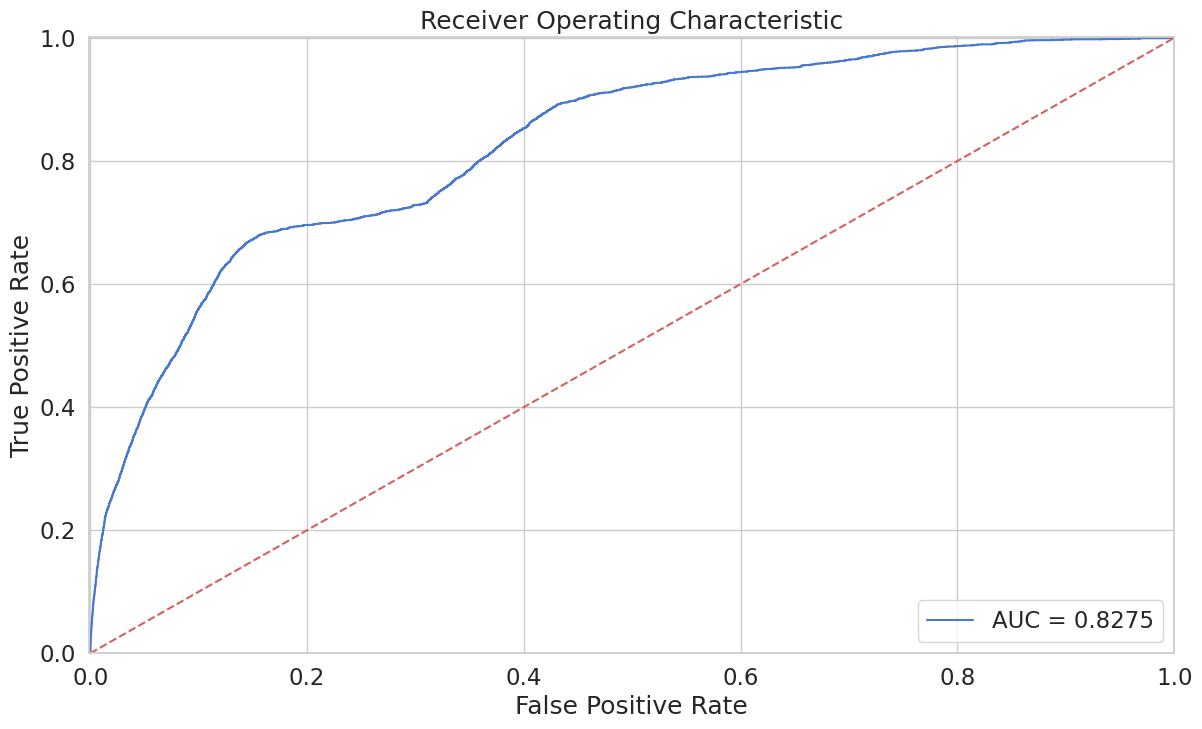

In [89]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.exposure, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

### Precision vs Recall

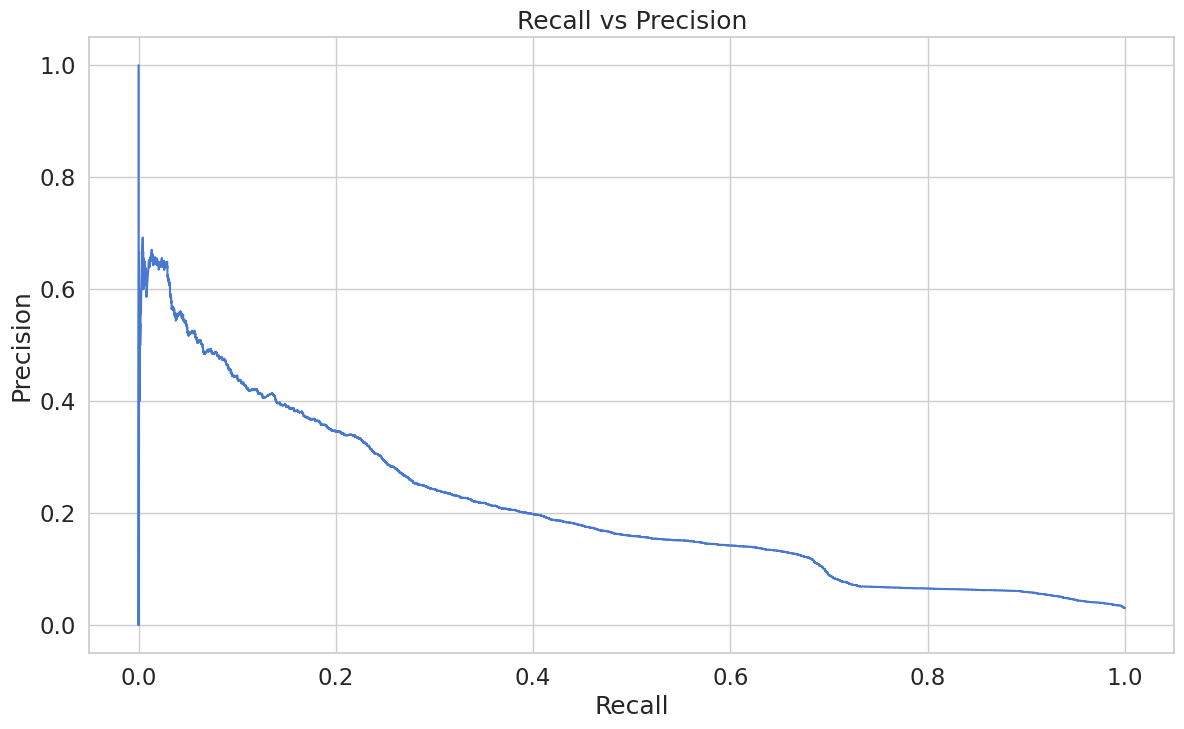

In [90]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.exposure, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

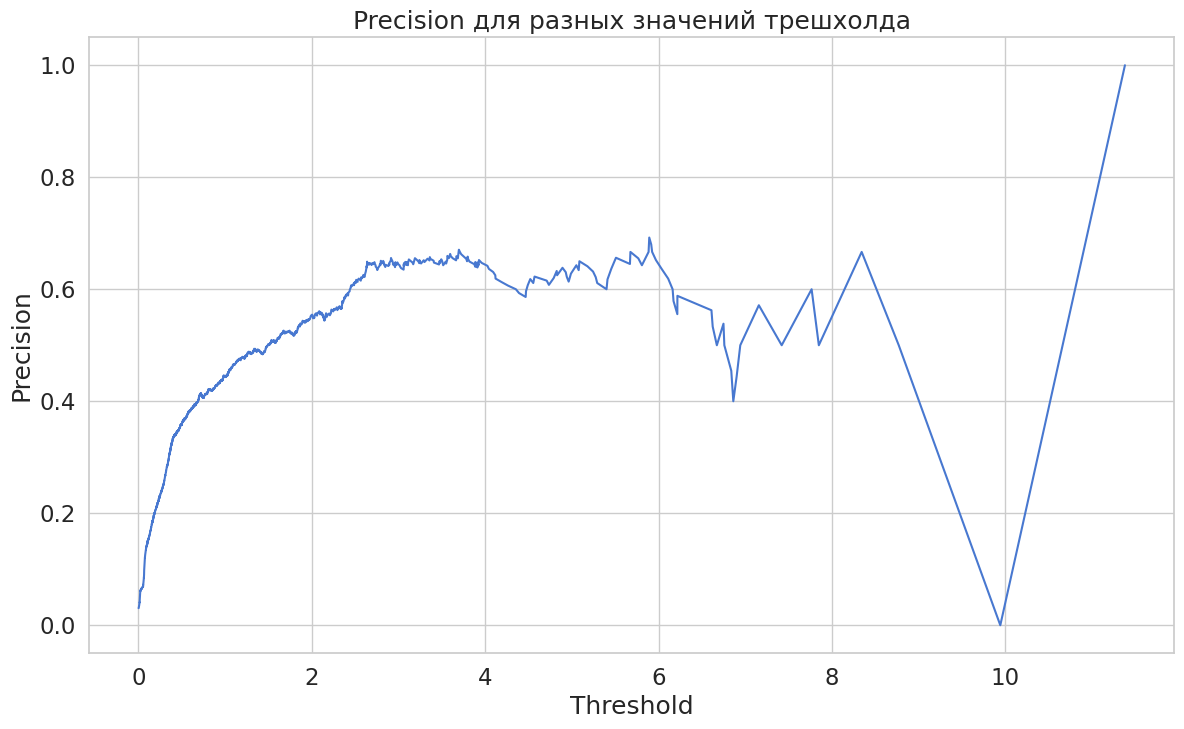

In [91]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

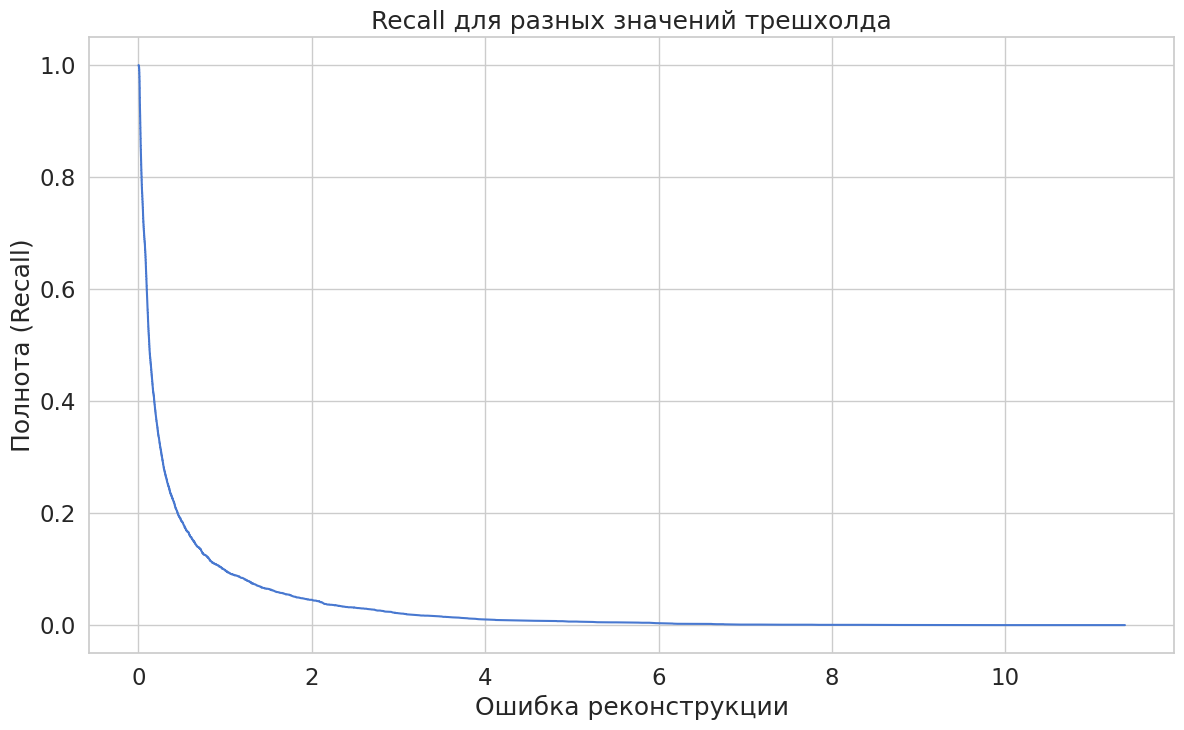

In [92]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

При увеличении ошибки реконструкции precision увеличивается, а recall необорот уменьшается

### Используем модель для того, чтобы сделать предсказание

In [93]:
threshold = 0.2

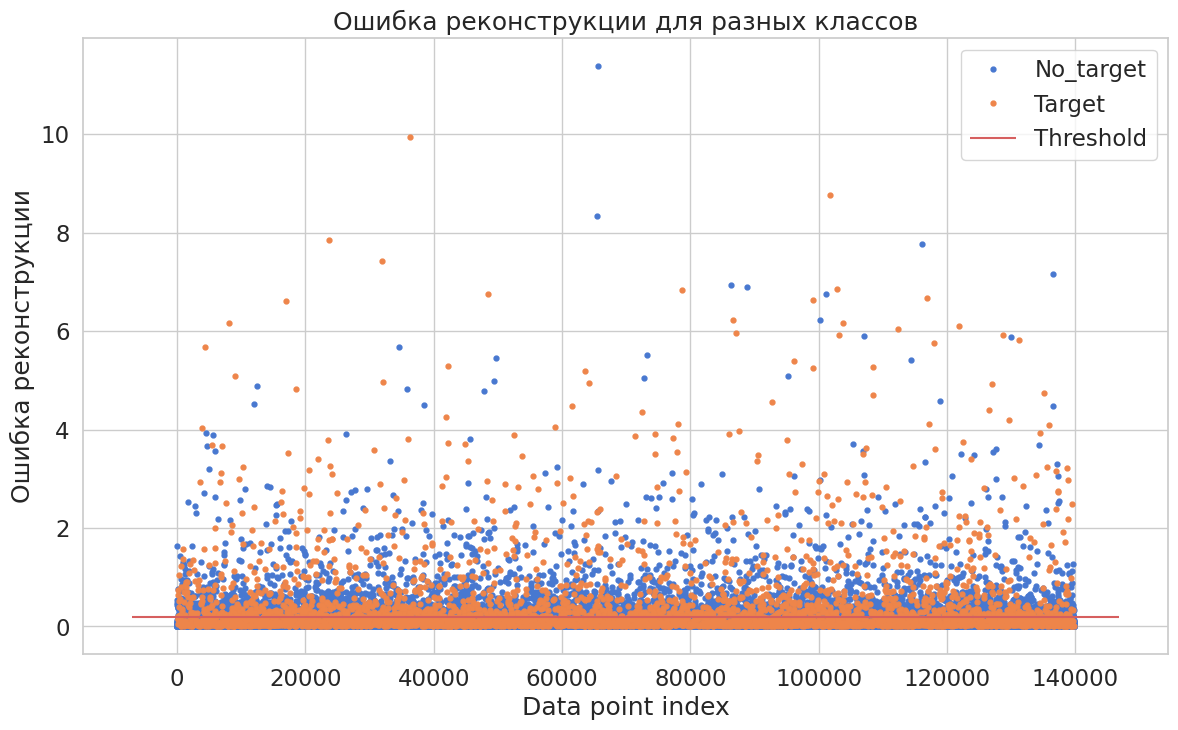

In [94]:
groups = reconstructionErrorDF.groupby('exposure')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Target" if name == 1 else "No_target")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

<ipython-input-95-e7b3425f9862>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


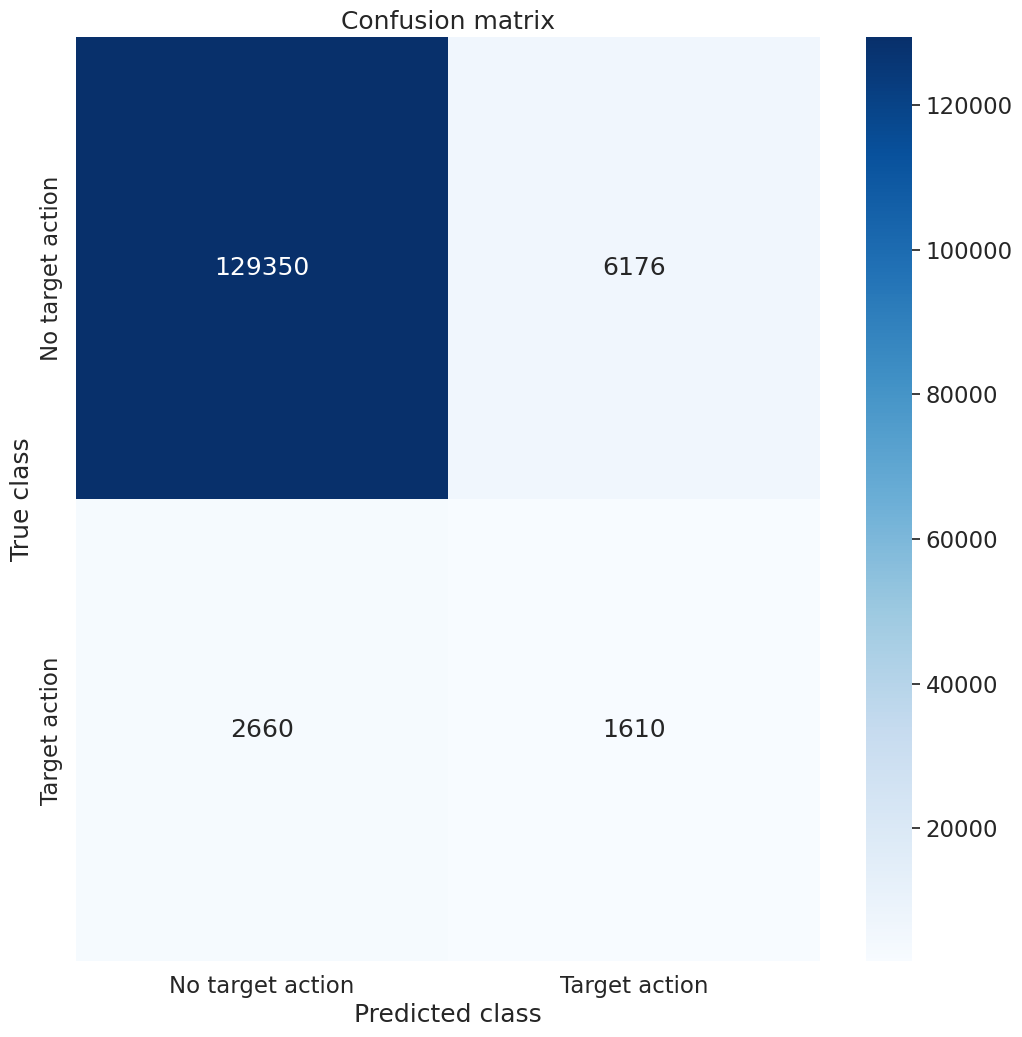

In [95]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.exposure, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Модель неплохо предсказывает неактивные действия пользователей, но количество неактивных действий классифицируемых активными достаточно много. Активные действия модель предсказывает не очень хорошо.